In [1]:
import tensorflow as tf
from tensorflow import keras 

In [2]:
import cv2
import os 
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
plt.imshow??


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
#Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
POS_PATH

'data\\positive'

In [10]:
#Make Directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
# https://vis-www.cs.umass.edu/lfw/

In [7]:
# Uncompress Tar GZ Labelled faces in the dataset
!tar -xf lfw.tgz

In [8]:
#Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        print(os.path.joi('lfw', directory, file))
        print(os.path.join(NEG_PATH, file))

In [14]:
#Establish a connection to the webcam
cap = cv2.VideoCapture(0)


In [11]:
import uuid

In [12]:
uuid.uuid1()

UUID('b4b94434-a746-11ee-b13c-951041b6e2e3')

In [15]:
while True: 
    ret, frame = cap.read()
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
                               
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    #Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    
   
        
    
    
    #Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# Release the webcam
cap.release()
#Close the image show frame
cv2.destroyAllWindows

<function destroyAllWindows>

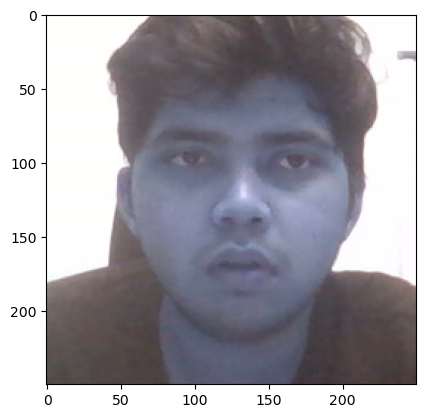

In [16]:
plt.imshow(frame)

In [17]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive =  tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [18]:
dir_test = anchor.as_numpy_iterator()

In [19]:
dir_test.next()

b'data\\anchor\\bfbc0e3e-a57b-11ee-ba43-951041b6e2e3.jpg'

In [20]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [21]:
img = preprocess('data\\anchor\\bbca85a6-a57b-11ee-90a5-951041b6e2e3.jpg')

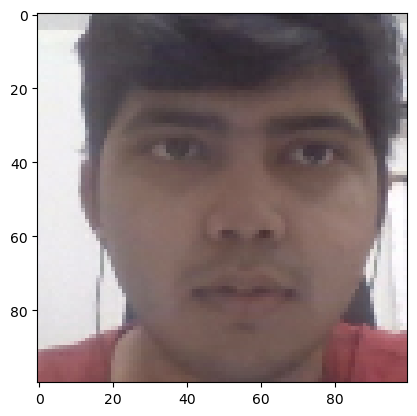

In [22]:
plt.imshow(img)

In [23]:
img.numpy().max()

1.0

In [24]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [25]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)                        

In [26]:
samples = data.as_numpy_iterator()

In [27]:
example = samples.next()

In [28]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [29]:
res = preprocess_twin(*example)

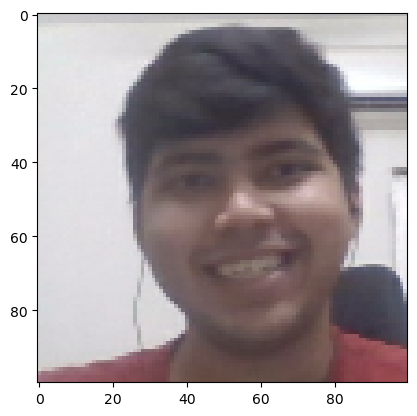

In [30]:
plt.imshow(res[1])

In [31]:
res[2]

1.0

In [32]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [33]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [34]:
samples = data.as_numpy_iterator()

In [35]:
samp = samples.next()

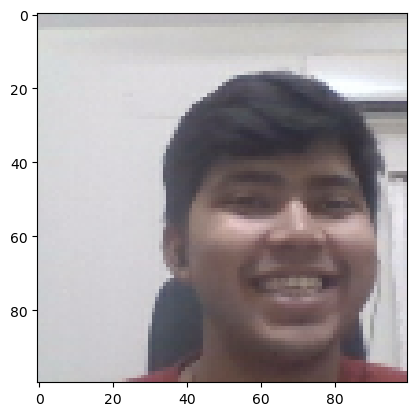

In [36]:
plt.imshow(samp[0])

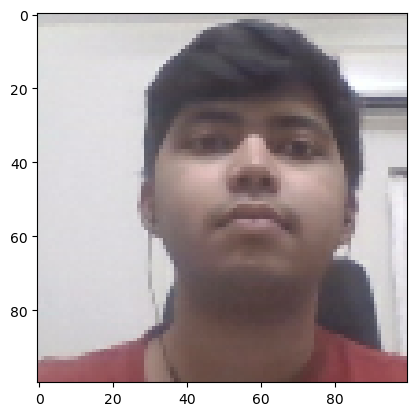

In [37]:
plt.imshow(samp[1])

samp[2]

In [38]:
#Training Partition 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [39]:
train_samples = train_data.as_numpy_iterator()

In [40]:
train_sample = train_samples.next()

In [41]:
#Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


# MODEL ENGINEERING

## Build Embedding Layer

In [42]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:
embedding = make_embedding()

In [44]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

# Build Distance Layer

In [45]:
#Siamese L1 Distance Class
class L1Dist(Layer):
    #Inheritance - init method
    def __init__(self, **kwargs):
        super().__init__()
        
    #Similarity Calculation 
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
        
    

In [46]:
l1 = L1Dist()

In [47]:
# We will pass through the anchor embedding and validation_embedding through our L1 Distance Layer then combine this into a dense layer and fully combine it to produce our final output
# Initially there is nothing inside of the L1 dist layer
l1

# Making Siamese Model 

In [48]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [49]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [50]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [51]:
siamese_layer = L1Dist()

In [52]:
distances = siamese_layer(inp_embedding, val_embedding)

In [53]:
classifier = Dense(1, activation='sigmoid')(distances)

In [54]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [55]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [56]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [57]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validaiton image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    #Combine siamesedistance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    
    

In [58]:
siamese_model = make_siamese_model()

In [59]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Training

## Setup Loss and Optimizer

In [60]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [61]:
opt = tf.keras.optimizers.Adam(1e-4)

## Establish Checkpoints

In [62]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## Build Train Step Function 

In [63]:
test_batch = train_data.as_numpy_iterator()

In [64]:
batch_1 = test_batch.next()

In [65]:
X = batch_1[:2]

In [66]:
y = batch_1[2]

In [67]:
y

array([1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [68]:
tf.losses.BinaryCrossentropy??

In [69]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## Build Training Loop 

In [70]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [71]:
def train_step(batch):
    # Implementation of your training logic goes here
    pass

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):  # Assuming 'data' is the correct variable name
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train the model

In [72]:
EPOCHS = 50

In [73]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 [==============================] - 0s 910us/step

 Epoch 2/50
27/27 [==============================] - 0s 1ms/step

 Epoch 3/50
27/27 [==============================] - 0s 963us/step

 Epoch 4/50
27/27 [==============================] - 0s 979us/step

 Epoch 5/50
27/27 [==============================] - 0s 905us/step

 Epoch 6/50
27/27 [==============================] - 0s 1ms/step

 Epoch 7/50
27/27 [==============================] - 0s 964us/step

 Epoch 8/50
27/27 [==============================] - 0s 889us/step

 Epoch 9/50
27/27 [==============================] - 0s 928us/step

 Epoch 10/50
27/27 [==============================] - 0s 970us/step

 Epoch 11/50
27/27 [==============================] - 0s 887us/step

 Epoch 12/50
27/27 [==============================] - 0s 911us/step

 Epoch 13/50
27/27 [==============================] - 0s 962us/step

 Epoch 14/50
27/27 [==============================] - 0s 983us/step

 Epoch 15/50
27/27 [==========================

# Evaluate Model

In [74]:
#Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

# Make Predictions

In [75]:
#Get a Batch of Test Data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [76]:
test_var = test_data.as_numpy_iterator().next()

In [77]:
y_true

array([1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

In [78]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 637ms/step


In [79]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]

# Calculate Metrics

In [80]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.22222222

In [81]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [82]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 157ms/step
0.35 0.7368421


# Viz Results

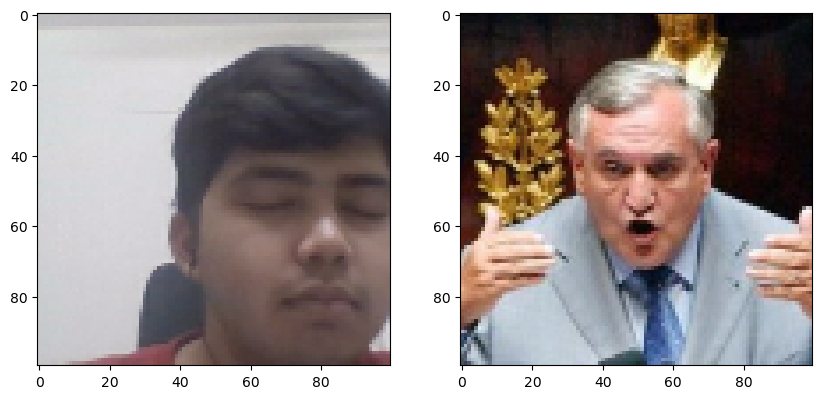

In [83]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

# Save Model

In [84]:
siamese_model.save('siamesemodelv2.h5')

C:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
L1Dist

__main__.L1Dist

In [86]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [87]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 301ms/step


array([[0.50031114],
       [0.49901384],
       [0.49922797],
       [0.49806568]], dtype=float32)

In [88]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Real Time Test


## Verification Function

In [89]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [90]:
os.listdir(os.path.join('application_data', 'verification_images'))

['13239d69-a57c-11ee-8005-951041b6e2e3.jpg',
 '1427dc76-a57c-11ee-89c6-951041b6e2e3.jpg',
 '142ee836-a57c-11ee-93ec-951041b6e2e3.jpg',
 '146d33a9-a57c-11ee-a193-951041b6e2e3.jpg',
 '14748a8c-a57c-11ee-93d7-951041b6e2e3.jpg',
 '1482d920-a57c-11ee-b9cc-951041b6e2e3.jpg',
 '1559b43d-a57c-11ee-8b55-951041b6e2e3.jpg',
 '1560de63-a57c-11ee-8815-951041b6e2e3.jpg',
 '15983def-a57c-11ee-9963-951041b6e2e3.jpg',
 '15f212e0-a57c-11ee-a86a-951041b6e2e3.jpg',
 '16c67d6d-a57c-11ee-9bda-951041b6e2e3.jpg',
 '16cd95b0-a57c-11ee-86d9-951041b6e2e3.jpg',
 '17a7b15c-a57c-11ee-84ce-951041b6e2e3.jpg',
 '17aec8d5-a57c-11ee-996f-951041b6e2e3.jpg',
 '191f8136-a57c-11ee-9945-951041b6e2e3.jpg',
 '192dcd54-a57c-11ee-92ff-951041b6e2e3.jpg',
 '19c60da4-a57c-11ee-ab26-951041b6e2e3.jpg',
 '19d25ab9-a57c-11ee-816b-951041b6e2e3.jpg',
 '19d9eb30-a57c-11ee-b6ef-951041b6e2e3.jpg',
 '1a041c25-a57c-11ee-adda-951041b6e2e3.jpg',
 '1a0fe511-a57c-11ee-abaf-951041b6e2e3.jpg',
 '1a170bc7-a57c-11ee-914e-951041b6e2e3.jpg',
 '1a1e5113

In [91]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# OpenCV real time Verification

In [94]:
cap = cv2.VideoCapture(0)

In [95]:
while True: 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: application_data\input_image\input_image.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]